In [1]:
! pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 21.2 MB/s 


In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as pydata
import torchmetrics as metrics

from matplotlib.pylab import plt
import sklearn.metrics as sk

import pickle

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_file = open(f'data/te_data.pkl', 'rb')
data = pickle.load(data_file)
data_file.close()

In [6]:
d = torch.tensor(data['x']).float()
target = torch.tensor(data['masks']).float()
d = d.reshape(d.shape[0], 1, d.shape[1], d.shape[2])

<ipython-input-6-0eae03b126b2>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  d = torch.tensor(data['x']).float()


In [7]:
BATCH_SIZE = 5

dataset = pydata.TensorDataset(d, target)
train_data, valid_data = pydata.random_split(dataset, [0.7, 0.3])
train_dl = pydata.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = pydata.DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Early attempt at the model - smaller channel sizes, fewer layers and skipped connection.

# class TEDetector(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.l1 = self.contract_block(1, 32, 2, 0)
#         self.l2 = self.contract_block(32, 64, 3, 1)

#         self.l3 = self.expand_block(64, 32, (1, 3), (0, 1))

#         # Need very specific paremeters for last layer
#         self.ex_conv1 = torch.nn.Conv2d(32, 1, (1, 3), stride=1, padding=(0, 1))
#         self.ex_bn1 = torch.nn.BatchNorm2d(1)
#         self.ex_conv2 = torch.nn.Conv2d(1, 1, (1, 3), stride=(2, 1), padding=(0, 1))
#         self.ex_bn2 = torch.nn.BatchNorm2d(1)
#         self.ex_contrans = torch.nn.ConvTranspose2d(1, 1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1), output_padding=(0, 1))

#     def forward(self, x):
#         conv1 = self.l1(x)
#         conv2 = self.l2(conv1)
#         upconv1 = self.l3(conv2)
#         # x = upconv1 + conv2
#         x = self.ex_conv1(upconv1)
#         x = nn.functional.relu(self.ex_bn1(x))
#         x = self.ex_conv2(x)
#         x = nn.functional.relu(self.ex_bn2(x))
#         x = self.ex_contrans(x)
#         return nn.functional.relu(x) # relu or no relu??

#     def contract_block(self, in_channels, out_channels, kernel_size, padding):

#         contract = nn.Sequential(
#             torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
#             torch.nn.BatchNorm2d(out_channels),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
#             torch.nn.BatchNorm2d(out_channels),
#             torch.nn.ReLU(),
#             torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#                                  )

#         return contract

#     def expand_block(self, in_channels, out_channels, kernel_size, padding, output_stride=2, output_padding=1):

#         expand = nn.Sequential(
#             torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
#             torch.nn.BatchNorm2d(out_channels),
#             torch.nn.ReLU(),
#             torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
#             torch.nn.BatchNorm2d(out_channels),
#             torch.nn.ReLU(),
#             torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=output_stride, padding=1, output_padding=output_padding) 
#                                 )
#         return expand

In [24]:
class LTRDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = self.contract_block(1, 24, 3, (2, 1))
        self.c2 = self.contract_block(24, 48, 3, 1)
        self.c3 = self.contract_block(48, 96, 3, 1)

        self.ex1 = self.expand_block(96, 48, 3, 1)
        self.ex2 = self.expand_block(48*2, 24, 3, 1)
        self.ex3 = self.expand_block(24*2, 1, 3, (2, 1), 2, (0, 1))

        self.fl = torch.nn.MaxPool2d(kernel_size=(15, 1), stride=1, padding=0)

    def forward(self, x):
        conv1 = self.c1(x)
        conv2 = self.c2(conv1)
        conv3 = self.c3(conv2)

        upconv1 = self.ex1(conv3)
        upconv2 = self.ex2(torch.cat([upconv1, conv2], 1))
        upconv3 = self.ex3(torch.cat([upconv2, conv1], 1))

        out = self.fl(upconv3)
        return out

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding, output_stride=2, output_padding=1):

        expand = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=output_stride, padding=1, output_padding=output_padding) 
                                )
        return expand

In [25]:
detector = LTRDetector()
detector.cuda()

TEDetector(
  (c1): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 1))
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(2, 1))
    (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (c2): Sequential(
    (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (c3): Sequential(
    (0): Conv2d(48, 96, kernel_si

In [10]:
# Metrics

# Did not utilize accuracy in the end
def calculate_accuracy(y_pred, target):
    predicted = torch.round(y_pred)

    correct = torch.sum(y_pred == target)

    return (correct / (y_pred.shape[0]*y_pred.shape[1])).item()

# Primary metric actually used
iou_metric = metrics.JaccardIndex(task='binary')
iou_metric.cuda()

BinaryJaccardIndex()

In [26]:
# Save for output, stats, and figures
vexample = {}
texample = {}
val_loss = []
train_loss = []
val_iou = []
train_iou = []

In [12]:
def train(model, iterator, optimizer, criterion, save_batch=False):
    epoch_loss = 0
    epoch_iou = 0
    epoch_sum = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()

        y_pred = model(x)
        y_pred = y_pred.reshape(y.shape[0], y.shape[1])

        loss = criterion(y_pred, y)
        iou_score = iou_metric(torch.round(y_pred), y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_iou += iou_score.item()
        epoch_sum += (torch.sum(y_pred).item() / y_pred.shape[0])
        epoch_acc += calculate_accuracy(y_pred, y)
        if save_batch:
          texample['prediction'] = torch.round(y_pred)
          texample['y'] = y
        
    return epoch_loss / len(iterator), epoch_iou / len(iterator), epoch_acc / len(iterator), epoch_sum / len(iterator)

In [13]:
def validate(model, iterator, criterion, save_batch=False):
    epoch_loss = 0
    epoch_iou = 0
    epoch_sum = 0
    epoch_acc = 0
    
    model.eval()

    with torch.no_grad():
       for (x, y) in iterator:
          x = x.cuda()
          y = y.cuda()
          
          y_pred = model(x)
          y_pred = y_pred.reshape(y.shape[0], y.shape[1])

          loss = criterion(y_pred, y)
          iou_score = iou_metric(torch.round(y_pred), y)

          epoch_loss += loss.item()
          epoch_iou += iou_score.item()
          epoch_sum += (torch.sum(y_pred).item() / y_pred.shape[0])
          epoch_acc += calculate_accuracy(y_pred, y)
          if save_batch:
            vexample['prediction'] = torch.round(y_pred)
            vexample['y'] = y
        
    return epoch_loss / len(iterator), epoch_iou / len(iterator), epoch_acc / len(iterator), epoch_sum / len(iterator)

In [27]:
EPOCHS = 100

best_validation_loss = float("inf")
optimizer = optim.Adam(detector.parameters(), lr = 1e-3)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(EPOCHS):
    save_batch = epoch+1 == EPOCHS
    t_loss, t_iou, t_acc, t_sum = train(detector, train_dl, optimizer, criterion, save_batch=save_batch)
    v_loss, v_iou, v_acc, v_sum = validate(detector, valid_dl, criterion, save_batch=save_batch)

    if epoch % 5 == 0:
      print(f'Train(Epoch{epoch+1}): loss = {t_loss} | iou = {t_iou} | accuracy = {t_acc} | sum = {t_sum}')
      print(f'Validate(Epoch{epoch+1}): loss = {v_loss} | iou = {v_iou} | accuracy = {v_acc} | sum = {v_sum}')
      print(' --- ')

    train_loss.append(t_loss)
    val_loss.append(v_loss)
    train_iou.append(t_iou)
    val_iou.append(v_iou)

    if epoch > 0 and best_validation_loss > v_loss:
        best_validation_loss = v_loss
        torch.save(detector, 'data/ltr_detector.pt')


Train(Epoch1): loss = 0.24337384676280088 | iou = 0.1293372110374374 | accuracy = 0.0 | sum = 5886.92461606378
Validate(Epoch1): loss = 0.24670992887789203 | iou = 0.294582522684528 | accuracy = 0.0 | sum = 7475.755191532259
 --- 
Train(Epoch6): loss = 0.20113853722402494 | iou = 0.4075643520240914 | accuracy = 0.0 | sum = 6213.79195339255
Validate(Epoch6): loss = 0.2320619451422845 | iou = 0.06294530054794685 | accuracy = 0.0 | sum = 3370.1033990675396
 --- 
Train(Epoch11): loss = 0.16222345471790392 | iou = 0.5377181466311625 | accuracy = 0.0 | sum = 6049.963424389982
Validate(Epoch11): loss = 0.3041983386201243 | iou = 5.378646751670468e-06 | accuracy = 0.0 | sum = 1301.3816548009072
 --- 
Train(Epoch16): loss = 0.11431026356677486 | iou = 0.6754760631959732 | accuracy = 1.8264840136534115e-07 | sum = 6042.763463184929
Validate(Epoch16): loss = 0.319485011600679 | iou = 0.4291648335995213 | accuracy = 0.0 | sum = 9822.012638608869
 --- 
Train(Epoch21): loss = 0.09132486015354117 | i

In [8]:
results = {
    'val_example': vexample,
    'train_example': texample,
    'val_loss': val_loss,
    'train_loss': train_loss,
    'val_iou': val_iou,
    'train_iou': train_iou
}

NameError: ignored

In [23]:
r_file = open(f'data/results.pkl', 'wb')

pickle.dump(results, r_file)

r_file.close()

In [7]:
r_file = open(f'data/results.pkl', 'rb')

results = pickle.load(r_file)

r_file.close()

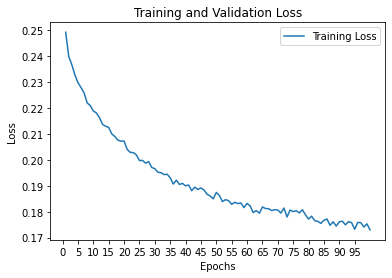

In [9]:
epochs = range(1, 101)

plt.plot(epochs, results['train_loss'], label='Training Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, 100, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

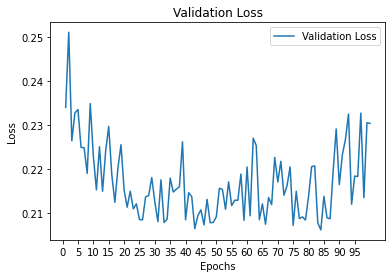

In [10]:
epochs = range(1, 101)

plt.plot(epochs, results['val_loss'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, 100, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

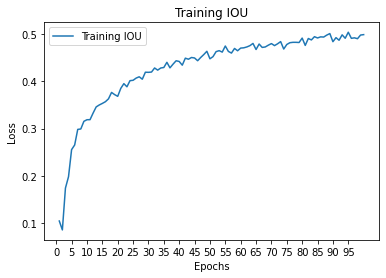

In [11]:
epochs = range(1, 101)

plt.plot(epochs, results['train_iou'], label='Training IOU')
 
# Add in a title and axes labels
plt.title('Training IOU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, 100, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

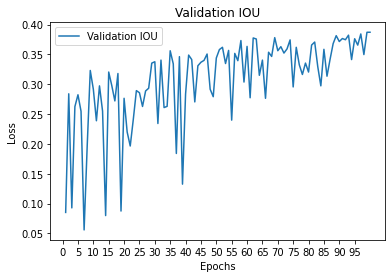

In [12]:
epochs = range(1, 101)

plt.plot(epochs, results['val_iou'], label='Validation IOU')
 
# Add in a title and axes labels
plt.title('Validation IOU')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, 100, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [13]:
vexample = results['val_example']

for i in range(5):
  totaly = torch.sum(vexample['y'][i]).item()
  totalpred = torch.sum(vexample['prediction'][i]).item()
  print(f'TE size: {totaly}')
  print(f'Total predicted locations: {totalpred}')

  te_start = (vexample['y'][i] == 1).nonzero(as_tuple=True)[0][0].item()
  te_end = (vexample['y'][i] == 1).nonzero(as_tuple=True)[0][-1].item()

  tp_sum = vexample['prediction'][i][te_start:te_end].sum()
  print(f'True positive sum: {tp_sum.item()}')

  fp_sum = vexample['prediction'][i][0:te_start].sum() + vexample['prediction'][i][te_end+1:-1].sum()
  print(f'False positive sum {fp_sum.item()}')
  print(' --- ')
  print('')


TE size: 6572.0
Total predicted locations: 8662.0
True positive sum: 6482.0
False positive sum 2179.0
 --- 

TE size: 1877.0
Total predicted locations: 8072.0
True positive sum: 1876.0
False positive sum 6195.0
 --- 

TE size: 14625.0
Total predicted locations: 6499.0
True positive sum: 6365.0
False positive sum 134.0
 --- 

TE size: 4989.0
Total predicted locations: 6936.0
True positive sum: 2984.0
False positive sum 3951.0
 --- 



IndexError: ignored

In [15]:
texample = results['train_example']

for i in range(5):
  totaly = torch.sum(texample['y'][i]).item()
  totalpred = torch.sum(texample['prediction'][i]).item()
  print(f'TE size: {totaly}')
  print(f'Total predicted locations: {totalpred}')

  te_start = (texample['y'][i] == 1).nonzero(as_tuple=True)[0][0].item()
  te_end = (texample['y'][i] == 1).nonzero(as_tuple=True)[0][-1].item()

  tp_sum = texample['prediction'][i][te_start:te_end].sum()
  print(f'True positive sum: {tp_sum.item()}')

  fp_sum = texample['prediction'][i][0:te_start].sum() + texample['prediction'][i][te_end+1:-1].sum()
  print(f'False positive sum {fp_sum.item()}')
  print(' --- ')
  print('')


TE size: 1881.0
Total predicted locations: 3447.0
True positive sum: 1820.0
False positive sum 1627.0
 --- 

TE size: 7518.0
Total predicted locations: 5022.0
True positive sum: 4518.0
False positive sum 503.0
 --- 



IndexError: ignored

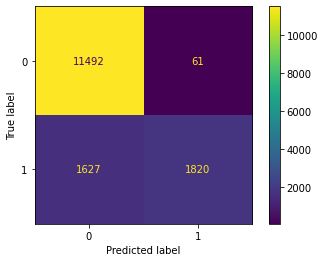

           --- 


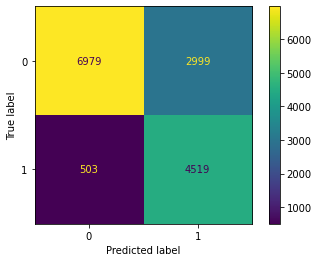

           --- 


IndexError: ignored

In [16]:
train_prediction_ex = torch.Tensor.cpu(results['train_example']['prediction']).detach().numpy()
train_target_ex = torch.Tensor.cpu(results['train_example']['y']).detach().numpy()

for i in range(5):
  cm = sk.confusion_matrix(train_prediction_ex[i], train_target_ex[i])
  disp = sk.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()
  print('           --- ')

In [ ]:
# t = (results['val_example']['prediction'][2] == 1).float().sum() + (results['val_example']['prediction'][2] == 0).float().sum()


for i, item in enumerate(results['val_example']['prediction'][2]):
  if item.item() != 1.0 and item.item() != 0.0:
    print(item.item())
    print(i)
    print(' --- ')


# results['val_example']['prediction'][2][0].item() == 0.0

2.0
4731
 --- 


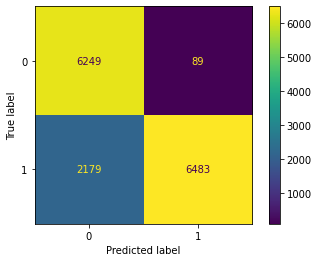

              --- 


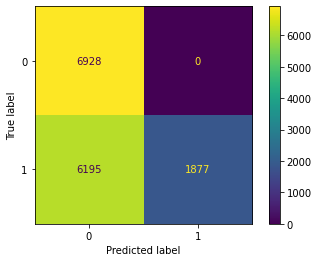

              --- 


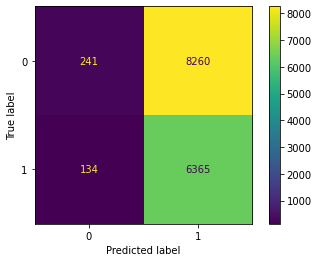

              --- 


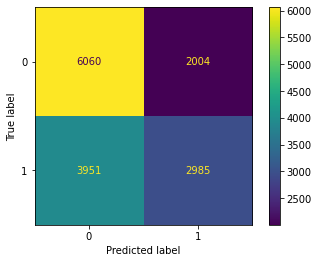

              --- 


IndexError: ignored

In [17]:
val_prediction_ex = torch.Tensor.cpu(results['val_example']['prediction']).detach().numpy()
val_target_ex = torch.Tensor.cpu(results['val_example']['y']).detach().numpy()

for i in range(5):
  cm = sk.confusion_matrix(val_prediction_ex[i], val_target_ex[i])
  disp = sk.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.show()
  print('              --- ')